# Numerics Investigation for Far Reaching Horizons

In [1]:
using Distributions
using LinearAlgebra
using Plots
using Test
using Sobol
using Optim
using Profile
using PProf
using Random

In [2]:
include("../rollout.jl")
include("../testfns.jl")

TestGramacyLee (generic function with 1 method)

In [34]:
# Global parameters
MAX_SGD_ITERS = 100
BATCH_SIZE = 5
HORIZON = 50
MC_SAMPLES = 10
BUDGET = 1;

In [35]:
# Setup toy problem
testfn = TestFunction(
    1, [0. 1.], [.5],
    x -> 0. + 1e-6*randn(),
    ∇x -> [0. + 1e-6*randn()]
)
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]

# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON+1);
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

In [36]:
# Gather initial samples/experimental data
N, θ = 1, [.25]
X = [.15, .85]
X = reshape(X, 1, length(X))
# ψ = kernel_matern52(θ);
ψ = kernel_scale(kernel_matern52, [1., θ...])
sur = fit_surrogate(ψ, X, testfn.f);

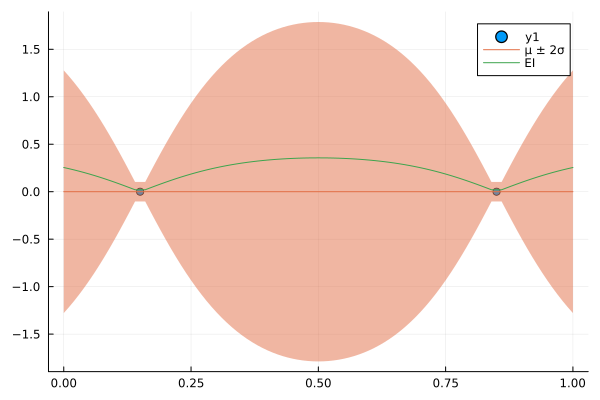

In [37]:
domain = filter(x -> !(x in X), lbs[1]:.01:ubs[1])
scatter(sur.X', sur.y)
plot!(domain, [sur([x]).μ for x in domain],
    ribbons=2*[sur([x]).σ for x in domain], label="μ ± 2σ")
plot!(domain, [sur([x]).EI for x in domain], label="EI")

In [38]:
eis, ∇eis = [], []
Ts = []
T = nothing
# for random_number_stream in [lds_rns, rns]
for random_number_stream in [lds_rns]
    rollout_ei = [0 0] # Sample mean and variance tuples
    ∇rollout_ei = [0 0] # Sample mean and variance tuples
    
    println("Total '|'s => $(length(domain))")
    for (ndx, x0) in enumerate(domain)
        print("|$x0")
        # Grab each input location and convert to a column vector
        x0 = [x0]

        αxs, ∇αxs = [], []
        # Monte-carlo integrate trajectory for x0
        for sample in 1:MC_SAMPLES
            # Make a copy of our surrogate to pass to the trajectory struct
            # for fantasized computations
            fsur = Base.deepcopy(sur)
            fantasy_ndx = size(fsur.X, 2) + 1

            # Rollout trajectory
            T = Trajectory(fsur, x0, fantasy_ndx; h=HORIZON, fopt=minimum(sur.y))
            rollout!(T, lbs, ubs; rnstream=random_number_stream[sample,:,:])

            # Evaluate rolled out trajectory
            push!(αxs, α(T))
            push!(∇αxs, first(∇α(T)))
            
            if ndx == length(domain)
                push!(Ts, T)
            end
        end # endfor sample

        # Average trajectories
        μx = sum(αxs) / length(αxs)
        ∇μx = sum(∇αxs) / length(αxs)
        σx = sum((αxs .- μx) .^ 2) / (MC_SAMPLES-1)
        ∇σx = sum((∇αxs .- ∇μx) .^ 2) / (MC_SAMPLES-1)

        # Update history
        # sx = sur(x0)
        # μx += ei(sx.μ, sx.σ, minimum(sur.y)) + poi(sx.μ, sx.σ, minimum(sur.y))
        rollout_ei = vcat(rollout_ei, [μx σx])
        ∇rollout_ei = vcat(∇rollout_ei, [∇μx ∇σx])
    end # endfor x0
    rollout_ei = rollout_ei[2:end, :]
    ∇rollout_ei = ∇rollout_ei[2:end, :];
    
    push!(eis, rollout_ei)
    push!(∇eis, ∇rollout_ei)
end

Total '|'s => 99
|0.0|0.01|0.02|0.03|0.04|0.05|0.06|0.07|0.08|0.09|0.1|0.11|0.12|0.13|0.14|0.16|0.17|0.18|0.19|0.2|0.21|0.22|0.23|0.24|0.25|0.26|0.27|0.28|0.29|0.3|0.31|0.32|0.33|0.34|0.35|0.36|0.37|0.38|0.39|0.4|0.41|0.42|0.43|0.44|0.45|0.46|0.47|0.48|0.49|0.5|0.51|0.52|0.53|0.54|0.55|0.56|0.57|0.58|0.59|0.6|0.61|0.62|0.63|0.64|0.65|0.66|0.67|0.68|0.69|0.7|0.71|0.72|0.73|0.74|0.75|0.76|0.77|0.78|0.79|0.8|0.81|0.82|0.83|0.84|0.86|0.87|0.88|0.89|0.9|0.91|0.92|0.93|0.94|0.95|0.96|0.97|0.98|0.99|1.0

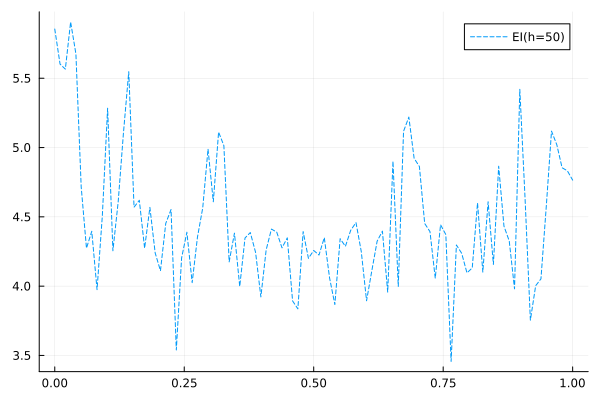

In [39]:
plot_domain = range(lbs[1], ubs[1], length=length(eis[1][:, 2]))
plot(
    plot_domain,
    eis[1][:, 1],
    # ribbons=sqrt.(eis[2][:, 2]),
    label="EI(h=$HORIZON)",
    linestyle=:dash,
)

In [40]:
function visualize1D(Ts::Vector{Any})
    p = plot(
        0:Ts[1].h, Ts[1].xfs[1, :], color=:red, label=nothing, xlabel="Decision Epochs (h=$(T.h))",
        ylabel="Control Space (xʳ)", title="Trajectory Visualization in 1D",
        xticks=(0:Ts[1].h, ["x$(i)" for i in 0:T.h]), xrotation=45, grid=false
    )
    
    vline!(0:Ts[1].h, color=:black, linestyle=:dash, linewidth=1, label=nothing, alpha=.2)
    scatter!(0:Ts[1].h, Ts[1].xfs[1, :], color=:red, label=nothing)
    yticks!(
        round.(range(lbs[1], ubs[1], length=11), digits=1)
    )

    best_ndx, best_step = best(Ts[1])
    scatter!([best_ndx-1], [best_step.x[1]], color=:green, label="Best Point")
    
    for i in 2:length(Ts)
        plot!(0:Ts[i].h, Ts[i].xfs[1, :], color=:red, label=nothing)
        scatter!(0:Ts[i].h, Ts[i].xfs[1, :], color=:red, label=nothing)
        yticks!(
            round.(range(lbs[1], ubs[1], length=11), digits=1)
        )

        best_ndx, best_step = best(Ts[i])
        scatter!([best_ndx-1], [best_step.x[1]], color=:green, label=nothing)
    end

    return p
end

visualize1D (generic function with 2 methods)

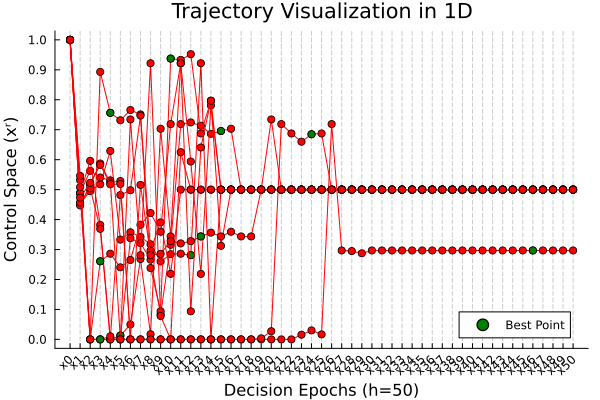

In [42]:
start, dend = 4, 4
visualize1D(Ts)